# Optimization Tutorial

Trey V. Wenger (c) July 2025

Here we demonstrate how to optimize the number of cloud components in a `AbsorptionModel` model.

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_zeeman_hi
print("bayes_zeeman_hi version:", bayes_zeeman_hi.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.23.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_zeeman_hi version: 0+unknown


## Model Definition and Simulated Data

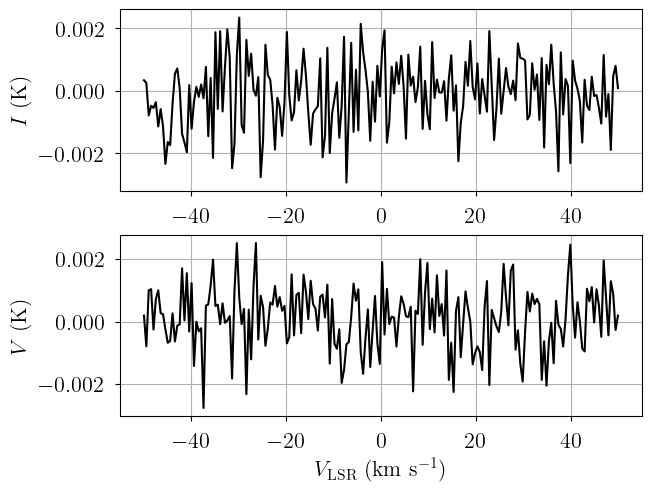

In [2]:
from bayes_spec import SpecData

# spectral axes definition
velo_axis = np.linspace(-50.0, 50.0, 200) # km s-1

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
rms = 0.001 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
stokesI = rms * np.random.randn(len(velo_axis))
stokesV = rms * np.random.randn(len(velo_axis))

dummy_data = {
    "I": SpecData(
        velo_axis,
        stokesI,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$I$ (K)",
    ),
    "V": SpecData(
        velo_axis,
        stokesV,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$V$ (K)",
    ),
}

# Plot dummy data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(dummy_data["I"].spectral, dummy_data["I"].brightness, "k-")
axes[1].plot(dummy_data["V"].spectral, dummy_data["V"].brightness, "k-")
axes[1].set_xlabel(dummy_data["V"].xlabel)
axes[0].set_ylabel(dummy_data["I"].ylabel)
_ = axes[1].set_ylabel(dummy_data["V"].ylabel)

In [3]:
from bayes_zeeman_hi import AbsorptionModel

# Initialize and define the model
n_clouds = 3
baseline_degree = 0
Tbg = 50.0 # K
model = AbsorptionModel(
    Tbg,
    dummy_data,
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_tau_total=10.0, # total optical depth prior width (km s-1)
    prior_fwhm2=200.0, # FWHM^2 prior width (km2 s-2)
    prior_velocity=[-20.0, 20.0],  # lower and upper limit of velocity prior (km/s)
    prior_Bparallel=[-20.0, 20.0], # lower and upper limit of Bparallel prior (uG)
    prior_leakage_fraction=0.01, # width of leakage fraction prior
)
model.add_likelihood()

In [4]:
from bayes_zeeman_hi import physics

# Simulation parameters
tau_total = np.array([25.0, 15.0, 10.0])
fwhm = np.array([20.0, 15.0, 10.0])
velocity = np.array([-10.0, 0.0, 10.0])
Bparallel = np.array([-15.0, 5.0, 15.0])
leakage_fraction = 0.001

sim_params = {
    "tau_total": tau_total,
    "fwhm2": fwhm**2.0,
    "velocity": velocity,
    "Bparallel": Bparallel,
    "leakage_fraction": leakage_fraction,
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observation
stokesI = model.model["I"].eval(sim_params, on_unused_input="ignore")
stokesV = model.model["V"].eval(sim_params, on_unused_input="ignore")

# Add noise due to Stokes I
extra_rms = 0.00005 * stokesI
stokesI += extra_rms * np.random.randn(len(extra_rms))
stokesV += extra_rms * np.random.randn(len(extra_rms))
rms += extra_rms

data = {
    "I": SpecData(
        velo_axis,
        stokesI,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$I$ (K)",
    ),
    "V": SpecData(
        velo_axis,
        stokesV,
        rms,
        xlabel=r"$V_{\rm LSR}$ (km s$^{-1}$)",
        ylabel=r"$V$ (K)",
    ),
}

In [5]:
sim_params

{'tau_total': array([25., 15., 10.]),
 'fwhm2': array([400., 225., 100.]),
 'velocity': array([-10.,   0.,  10.]),
 'Bparallel': array([-15.,   5.,  15.]),
 'leakage_fraction': 0.001}

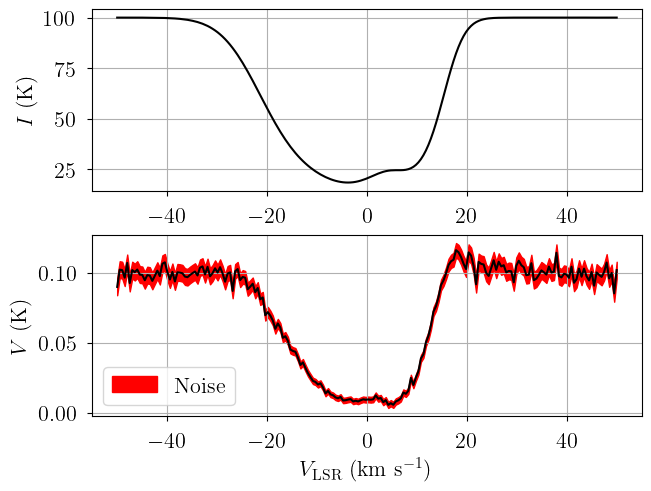

In [6]:
# Plot data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["I"].spectral, data["I"].brightness, "k-")
axes[1].plot(data["V"].spectral, data["V"].brightness, "k-")
axes[1].fill_between(data["V"].spectral, data["V"].brightness-data["V"].noise, data["V"].brightness+data["V"].noise, color="r", label="Noise")
axes[1].set_xlabel(data["V"].xlabel)
axes[0].set_ylabel(data["I"].ylabel)
axes[1].legend(loc='best')
_ = axes[1].set_ylabel(data["V"].ylabel)

## `Optimize`

We use the `Optimize` class for optimization.

In [7]:
from bayes_spec import Optimize

# Initialize optimizer
opt = Optimize(
    AbsorptionModel,  # model definition
    Tbg,
    data,  # data dictionary
    max_n_clouds=5,  # maximum number of clouds
    baseline_degree=baseline_degree,  # polynomial baseline degree
    seed=1234,  # random seed
    verbose=True,  # verbosity
)

# Define each model
opt.add_priors(
    prior_tau_total=10.0, # total optical depth prior width (km s-1)
    prior_fwhm2=200.0, # FWHM^2 prior width (km2 s-2)
    prior_velocity=[-20.0, 20.0],  # lower and upper limit of velocity prior (km/s)
    prior_Bparallel=[-20.0, 20.0], # lower and upper limit of Bparallel prior (uG)
    prior_leakage_fraction=0.01, # width of leakage fraction prior
)
opt.add_likelihood()

`Optimize` has created `max_n_clouds` models, where `opt.models[1]` has `n_clouds=1`, `opt.models[2]` has `n_clouds=2`, etc.

In [8]:
print(opt.models[4])
print(opt.models[4].n_clouds)

4


By default (`approx=True`), the optimization algorithm first loops over every model and approximates the posterior distribution using variational inference. This is generally a bad idea, since VI is only an approximation and tends to struggle with complex models. Instead we use `approx=False` to sample every model with MCMC. This is slower but more robust.

We can supply arguments to `fit` and `sample` via dictionaries. Whichever model is the first to have a BIC within `bic_threshold` of the minimum BIC is the "best" model. The algorithm will terminate early if successive models have increasing BICs or fail to converge.

In [9]:
fit_kwargs = {
    "rel_tolerance": 0.005,
    "abs_tolerance": 0.005,
    "learning_rate": 0.001,
}
sample_kwargs = {
    "chains": 8,
    "cores": 8,
    "n_init": 200_000,
    "init_kwargs": fit_kwargs,
    "nuts_kwargs": {"target_accept": 0.9},
}
solve_kwargs = {
    "init_params": "random_from_data",
    "n_init": 10,
    "max_iter": 1_000,
    "kl_div_threshold": 0.1,
}
opt.optimize(
    bic_threshold=10.0,
    sample_kwargs=sample_kwargs,
    fit_kwargs=fit_kwargs,
    solve_kwargs=solve_kwargs,
    approx=False,
    start_spread = {"velocity_norm": [0.25, 0.75]},
)

Null hypothesis BIC = 3.070e+10
Sampling n_cloud = 1 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 21300
Interrupted at 21,299 [10%]: Average Loss = 2.4485e+09
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm, leakage_fraction_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 1 solution = 0 BIC = 3.033e+08

Sampling n_cloud = 2 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 28800
Interrupted at 28,799 [14%]: Average Loss = 7.4481e+08
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm, leakage_fraction_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 8 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 2 solution = 0 BIC = 1.230e+07

Sampling n_cloud = 3 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 31100
Interrupted at 31,099 [15%]: Average Loss = 3.5978e+08
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm, leakage_fraction_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 146 seconds.


Adding log-likelihood to trace


Output()

GMM converged to unique solution
n_cloud = 3 solution = 0 BIC = -3.327e+03

Sampling n_cloud = 4 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 54500
Interrupted at 54,499 [27%]: Average Loss = 1.4507e+08
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm, leakage_fraction_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 336 seconds.


Adding log-likelihood to trace


Output()

No solution found!
0 of 8 chains appear converged.

Stopping criteria met.
Sampling n_cloud = 5 posterior...
Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 47600
Interrupted at 47,599 [23%]: Average Loss = 1.4018e+08
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [tau_total_norm, fwhm2_norm, velocity_norm, Bparallel_norm, leakage_fraction_norm]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 345 seconds.


Adding log-likelihood to trace


Output()

There were 769 divergences in converged chains.
No solution found!
0 of 8 chains appear converged.

Stopping criteria met.
Stopping early.


In [10]:
opt.best_model.n_clouds

3

Sampling: [I, V]


Output()

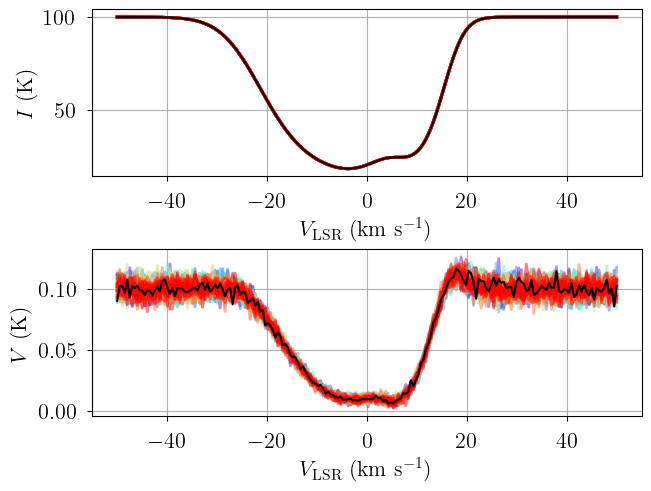

In [11]:
from bayes_spec.plots import plot_predictive

posterior = opt.best_model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
axes = plot_predictive(opt.best_model.data, posterior.posterior_predictive)
axes.ravel()[0].sharex(axes.ravel()[1])

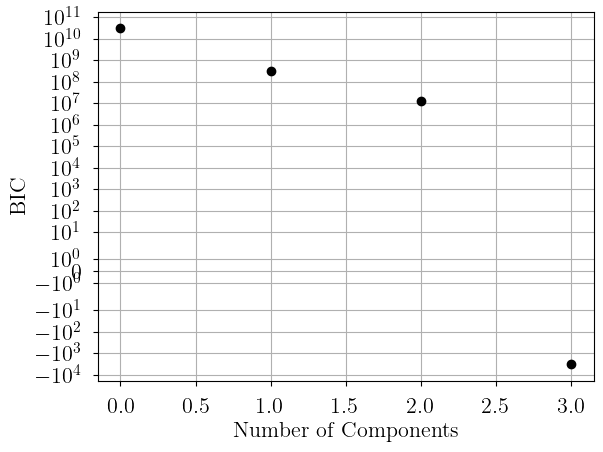

In [15]:
plt.plot(opt.bics.keys(), opt.bics.values(), 'ko')
plt.xlabel("Number of Components")
plt.ylabel("BIC")
plt.yscale("symlog")